In [125]:
!pip install pandas numpy
!pip install matplotlib
import pandas as pd
import numpy as np
import os 
import re
import matplotlib.pyplot as plt

In [126]:
main_df = pd.read_csv('CJQ06.20260202004354.csv')
main_df = main_df.drop(["STATISTIC","C02480V03003","C02481V03160","TLIST(Q1)","UNIT"],axis=1)

main_df["Year"] = main_df["Quarter"].str.slice(0,4)
main_df = main_df.drop("Quarter",axis=1)
main_df = main_df.groupby(
    ["Year", "Garda Division", "Type of Offence"],  
    as_index=False  
)["VALUE"].sum()
main_df


,Year,Garda Division,Type of Offence,VALUE
0,2003,Cavan/Monaghan Garda Division,"Abandoning a child, child neglect and cruelty ...",14.0
1,2003,Cavan/Monaghan Garda Division,Abduction of person under 16 years of age (0512),0.0
2,2003,Cavan/Monaghan Garda Division,Aggravated burglary (0711),6.0
3,2003,Cavan/Monaghan Garda Division,Arson (1211),25.0
4,2003,Cavan/Monaghan Garda Division,"Assault causing harm, poisoning (034)",131.0
...,...,...,...,...
54735,2025,Wicklow Garda Division,Threat to kill or cause serious harm (0313),20.0
54736,2025,Wicklow Garda Division,Trespass offences (132),65.0
54737,2025,Wicklow Garda Division,Unseaworthy/dangerous use of boat or ship (0423),0.0
54738,2025,Wicklow Garda Division,Vehicle tax/registration offences (142),143.0


In [127]:
unique_division = main_df['Garda Division'].unique().tolist()
#replacing "/" with "-" to make writing filepaths easier
unique_division = [div.replace('/', '-') for div in unique_division]
    
unique_division

['Cavan-Monaghan Garda Division',
 'Clare Garda Division',
 'Cork City Garda Division',
 'Cork North Garda Division',
 'Cork West Garda Division',
 'D.M.R. Eastern Garda Division',
 'D.M.R. North Central Garda Division',
 'D.M.R. Northern Garda Division',
 'D.M.R. South Central Garda Division',
 'D.M.R. Southern Garda Division',
 'D.M.R. Western Garda Division',
 'Donegal Garda Division',
 'Galway Garda Division',
 'Kerry Garda Division',
 'Kildare Garda Division',
 'Kilkenny-Carlow Garda Division',
 'Laois-Offaly Garda Division',
 'Limerick Garda Division',
 'Louth Garda Division',
 'Mayo Garda Division',
 'Meath Garda Division',
 'Roscommon-Longford Garda Division',
 'Sligo-Leitrim Garda Division',
 'Tipperary Garda Division',
 'Waterford Garda Division',
 'Westmeath Garda Division',
 'Wexford Garda Division',
 'Wicklow Garda Division']

In [128]:
#seperate our big dataframe into a set of small dataframes based on each garda division
sub_dfs = {} # key = garda division, value = dataframe
for division in unique_division:
    sub_df = main_df.loc[main_df["Garda Division"]==division]
    sub_dfs[division] = sub_df
    

In [129]:
#writing each sub_df to its own individual csv file for future reference and ease
curr_dir = os.getcwd()
if not os.path.exists(os.path.join(curr_dir,"counties")):
    os.mkdir(os.path.join(curr_dir,"counties"),mode=0o755)

for division in sub_dfs.keys():
    division_path = os.path.join(curr_dir, "counties", division)
    os.makedirs(division_path, exist_ok=True)

    file_path = os.path.join(division_path, f"{division}_crime.csv")
    sub_dfs[division].to_csv(file_path, index=False)

In [ ]:

clare_df = pd.read_csv("counties\\Clare Garda Division\\Clare Garda Division_crime.csv")
clare_df

,Year,Garda Division,Type of Offence,VALUE
0,2003,Clare Garda Division,"Abandoning a child, child neglect and cruelty ...",2.0
1,2003,Clare Garda Division,Abduction of person under 16 years of age (0512),0.0
2,2003,Clare Garda Division,Aggravated burglary (0711),7.0
3,2003,Clare Garda Division,Arson (1211),40.0
4,2003,Clare Garda Division,"Assault causing harm, poisoning (034)",94.0
...,...,...,...,...
1950,2025,Clare Garda Division,Threat to kill or cause serious harm (0313),30.0
1951,2025,Clare Garda Division,Trespass offences (132),27.0
1952,2025,Clare Garda Division,Unseaworthy/dangerous use of boat or ship (0423),0.0
1953,2025,Clare Garda Division,Vehicle tax/registration offences (142),70.0


In [ ]:
#obtaining crime details

pattern = r'\((\d{2})\)'

clare_crime_categories = clare_df.loc[clare_df["Type of Offence"].str.contains(pattern, regex=True)]



C:\Users\downe\AppData\Local\Temp\ipykernel_24112\2107324177.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  clare_crime_categories = clare_df.loc[clare_df["Type of Offence"].str.contains(pattern, regex=True)]


In [132]:
clare_crime_categories["Type of Offence"] = clare_crime_categories["Type of Offence"].str.replace(r"\s\(\d{2}\)$", "", regex=True)
crimes = clare_crime_categories["Type of Offence"].unique()
crimes

<StringArray>
[   'Attempts/threats to murder, assaults, harassments and related offences',
                                             'Burglary and related offences',
                                                  'Controlled drug offences',
                       'Damage to property and to the environment  offences',
                                               'Dangerous or negligent acts',
                                     'Fraud, deception and related offences',
                                               'Homicide & related offences',
                                           'Kidnapping and related offences',
 'Offences against government, justice procedures and organisation of crime',
                                         'Offences not elsewhere classified',
                               'Public order and other social code offences',
                                                 'Road and traffic offences',
                                 'Robbery, extorti

In [133]:
## Make a figure of 16 graphs, each containing information as to crime in each category over the years
crimes_since_2003 = []
for crime in crimes:
    y = clare_crime_categories[clare_crime_categories["Type of Offence"] == f"{crime}"]["VALUE"]
    x =  clare_crime_categories[clare_crime_categories["Type of Offence"] == f"{crime}"]["Year"]
    temp = [x,y]
    crimes_since_2003.append(temp)



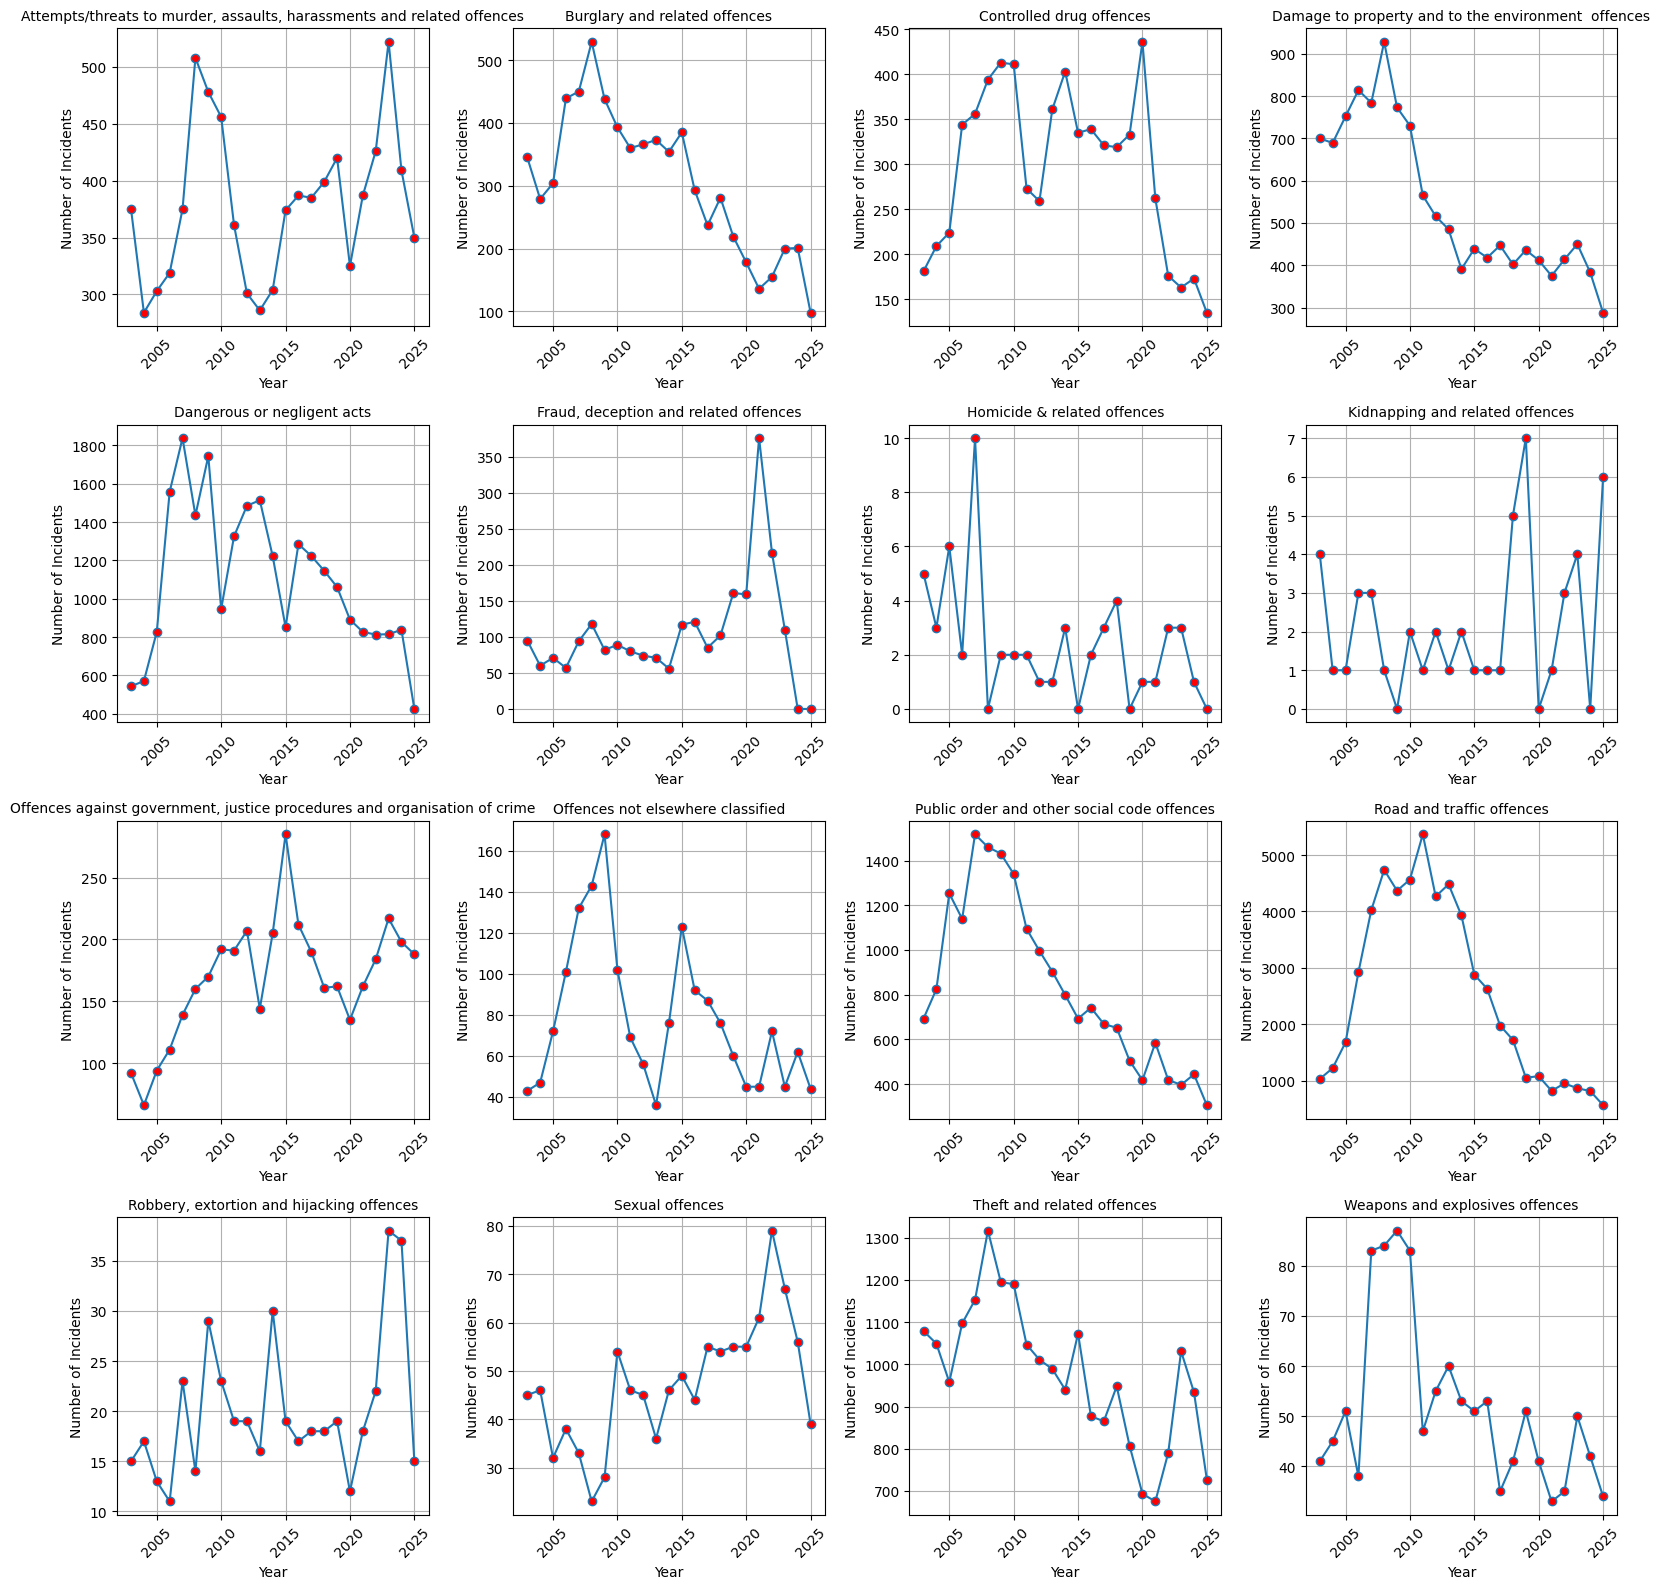

In [134]:
fig, ax = plt.subplots(nrows = 4, ncols = 4,figsize=(16,16))


for i,crime in enumerate(crimes_since_2003):
    row = i//4
    col = i%4
    ax[row,col].plot(crime[0], crime[1], marker='o', linestyle='-', markerfacecolor='red')
    ax[row,col].set_title(f"{crimes[i]}",fontsize=10)
    ax[row,col].set_xlabel("Year")
    ax[row,col].set_ylabel("Number of Incidents")
    ax[row,col].grid(True)
    ax[row,col].tick_params(axis='x',rotation=45)


plt.tight_layout()
plt.savefig("counties/Clare Garda Division/clare_crimes.jpg")
